In [1]:
import argparse
from dataclasses import dataclass
import json
import logging
import os
import random
import sys
import time
import warnings

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler

import transformers
import wandb
from tqdm.auto import tqdm, trange


logger = logging.getLogger(__name__)
logging.basicConfig(
    format="%(asctime)s: %(message)s",
    datefmt="%m/%d/%Y %H:%M:%S",
    level=logging.INFO,
)

In [2]:
@dataclass
class CustomArguments(transformers.TrainingArguments):
    sample_train: int = 0
    sample_eval: int = 0
    num_choices: int = 0
    model_name_or_path: str = "asdf"  # this is no longer a TrainingArgument attribute
        
    # python dataclasses cannot have positional attributes in subclass,
    # so give all attributes defaults and then make sure they are changed
    def __post_init__(self):
        if not (self.sample_train * self.sample_eval * self.num_choices) or \
               self.model_name_or_path == "asdf":  # make sure none are still default value
            raise TypeError("__init__ missing required argument(s)")

def get_args():
    """ Set hyperparameters """
    args = CustomArguments(
        output_dir="checkpoint",
        model_name_or_path="roberta-base",
        overwrite_output_dir=True,
        do_train=False,  # Zero shot
        do_eval=True,
        per_device_eval_batch_size=1,
        learning_rate=1e-5,  # Should not matter because not training
        weight_decay=0.1,
        save_total_limit=2,
        seed=123,
        sample_train=200,
        sample_eval=-1,
        num_choices=2,
    )
    
    return args

In [3]:
def get_data(file_path, sample, num_choices):
    data_file = open(file_path, "r")
    logger.info("Reading QA instances from jsonl dataset at: %s", file_path)
    item_jsons = []
    item_ids = []
    questions = []
    choice_lists = []
    answer_ids = []
    for line in data_file:
        item_jsons.append(json.loads(line.strip()))

    if sample != -1:
        item_jsons = random.sample(item_jsons, sample)
        logger.info("Sampling %d examples", sample)

    for item_json in tqdm(item_jsons,total=len(item_jsons)):
        item_id = item_json["id"]

        question_text = item_json["question"]["stem"]

        choice_label_to_id = {}
        choice_text_list = []
        choice_context_list = []
        choice_label_list = []
        choice_annotations_list = []

        any_correct = False
        choice_id_correction = 0

        for choice_id, choice_item in enumerate(item_json["question"]["choices"]):
            choice_label = choice_item["label"]
            choice_label_to_id[choice_label] = choice_id - choice_id_correction
            choice_text = choice_item["text"]

            choice_text_list.append(choice_text)
            choice_label_list.append(choice_label)

            if item_json.get('answerKey') == choice_label:
                if any_correct:
                    raise ValueError("More than one correct answer found for {item_json}!")
                any_correct = True


        if not any_correct and 'answerKey' in item_json:
            raise ValueError("No correct answer found for {item_json}!")


        answer_id = choice_label_to_id.get(item_json.get("answerKey"))
        # Pad choices with empty strings if not right number
        if len(choice_text_list) != num_choices:
            choice_text_list = (choice_text_list + num_choices * [''])[:num_choices]
            choice_context_list = (choice_context_list + num_choices * [None])[:num_choices]
            if answer_id is not None and answer_id >= num_choices:
                logging.warning(f"Skipping question with more than {num_choices} answers: {item_json}")
                continue

        item_ids.append(item_id)
        questions.append(question_text)
        choice_lists.append(choice_text_list)
        answer_ids.append(answer_id)

    data_file.close()
    return questions, choice_lists, answer_ids

In [4]:
class RoBERTaDataset(Dataset):
    
    def __init__(self, questions, choices, answer_ids, tokenizer):
        questions = [question.replace('[MASK]','<extra_id_0>') for question in questions]
        out = tokenizer(questions)
        self.input_ids = out["input_ids"]
        self.attention_mask = out["attention_mask"]
        self.questions = questions
        self.choices = choices
        self.answer_ids = answer_ids
        
    def __len__(self):
        return len(self.questions)

    def __getitem__(self, i):
        return {
            "input_ids": self.input_ids[i], 
            "attention_mask": self.attention_mask[i], 
            "choice_list": self.choices[i], 
            "answer_id": self.answer_ids[i],
        }

In [5]:
args = get_args()
args.model_name_or_path = "t5-large" # "bert-large-uncased-whole-word-masking"  # "roberta-large"
transformers.set_seed(args.seed)
model = transformers.T5ForConditionalGeneration.from_pretrained("t5-large").cuda()
tokenizer = transformers.AutoTokenizer.from_pretrained(args.model_name_or_path)
train_questions, train_choices, train_answer_ids = get_data("data/number_comparison_age_compare_masked_train.jsonl", args.sample_train, args.num_choices)
eval_questions, eval_choices, eval_answer_ids = get_data("data/number_comparison_age_compare_masked_dev.jsonl", args.sample_eval, args.num_choices)
train_dataset = RoBERTaDataset(train_questions, train_choices, train_answer_ids, tokenizer)
eval_dataset = RoBERTaDataset(eval_questions, eval_choices, eval_answer_ids, tokenizer)

05/31/2021 10:51:55: Reading QA instances from jsonl dataset at: data/number_comparison_age_compare_masked_train.jsonl
05/31/2021 10:51:55: Sampling 200 examples


  0%|          | 0/200 [00:00<?, ?it/s]

05/31/2021 10:51:55: Reading QA instances from jsonl dataset at: data/number_comparison_age_compare_masked_dev.jsonl


  0%|          | 0/500 [00:00<?, ?it/s]

In [6]:
input_ids = tokenizer("A 41 year old person age is <extra_id_0> than a 42 year old person.", add_special_tokens=False, return_tensors="pt").input_ids
labels = tokenizer("<extra_id_0> older <extra_id_1> </s>", add_special_tokens=False, return_tensors="pt").input_ids
outputs = model(input_ids=input_ids.cuda(), labels=labels.cuda())

In [11]:
outputs = model(input_ids=input_ids.cuda(), decoder_input_ids=input_ids.cuda())

In [35]:
YOUNG_ID = tokenizer("blank", add_special_tokens=False).input_ids
YOUNG_ID

[11460]

In [12]:
logits = outputs.logits

In [13]:
logits[0, 1, YOUNG_ID]

tensor(-17.3360, device='cuda:0', grad_fn=<SelectBackward>)

In [36]:
def evaluate(args, model, tokenizer, eval_dataset):
    eval_sampler = SequentialSampler(eval_dataset)
    eval_dataloader = DataLoader(eval_dataset, sampler=eval_sampler, batch_size=args.per_device_eval_batch_size)

    logger.info(f"***** Running evaluation  *****")
    logger.info(f"  Num examples = {len(eval_dataset)}")
    logger.info(f"  Batch size = {args.eval_batch_size}")
    eval_dataloader = tqdm(eval_dataloader, desc="Evaluating")
    
    YOUNG_ID = tokenizer.encode(" younger", add_special_tokens=False)
    OLD_ID = tokenizer.encode(" older", add_special_tokens=False)
    YEAR_ID = tokenizer.encode(" year", add_special_tokens=False)
    assert len(YOUNG_ID) == 1 and len(OLD_ID) == 1 and len(YEAR_ID) == 1
    YOUNG_ID = YOUNG_ID[0]
    OLD_ID = OLD_ID[0]
    YEAR_ID = YEAR_ID[0]
    LABELS = tokenizer("<extra_id_0> blank <extra_id_1> </s>", add_special_tokens=False, return_tensors="pt")
    LABELS = LABELS.input_ids.cuda()  # from testing, "blank" can be any word and results are the same
    
    all_preds = []
    first_age = []
    second_age = []
    
    model.eval()
    for batch in eval_dataloader:
        
        YEAR_INDEX1 = batch["input_ids"].index(YEAR_ID)
        YEAR_INDEX2 = batch["input_ids"].index(YEAR_ID, YEAR_INDEX1+1)
        age1 = tokenizer.decode(batch["input_ids"][YEAR_INDEX1-1])
        age2 = tokenizer.decode(batch["input_ids"][YEAR_INDEX2-1])
        # print(age1, age2)
        
        first_age.append(age1)
        second_age.append(age2)
                
        del batch["choice_list"] 
        del batch["answer_id"] 
        for key in batch:
            batch[key] = torch.stack(batch[key], dim=-1).cuda()
  
        outputs = model(input_ids=batch["input_ids"], labels=LABELS)
        logits = outputs.logits
        if logits[0, 1, YOUNG_ID] < logits[0, 1, OLD_ID]:
            all_preds.append(1)
        else:
            all_preds.append(0)
#         with torch.no_grad():
#             outputs = model.generate(input_ids=batch["input_ids"], 
#                           num_beams=200, num_return_sequences=20,
#                           max_length=5)
            
#             match = False
#             for seq in outputs:
#                 if YOUNG_ID in seq:
#                     all_preds.append(0)
#                     match = True
#                     break
#                 elif OLD_ID in seq:
#                     all_preds.append(1)
#                     match = True
#                     break
            
#             if not match:
#                 all_preds.append(-1)
        
    first_age = [int(age) for age in first_age]
    second_age = [int(age) for age in second_age]
    return all_preds, first_age, second_age

In [37]:
all_preds, first_age, second_age = evaluate(args, model, tokenizer, eval_dataset)

05/31/2021 11:05:04: ***** Running evaluation  *****
05/31/2021 11:05:04:   Num examples = 500
05/31/2021 11:05:04:   Batch size = 1


Evaluating:   0%|          | 0/500 [00:00<?, ?it/s]

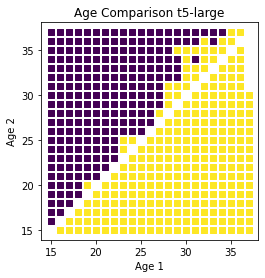

In [38]:
plt.scatter(first_age, second_age, c=all_preds, marker="s")
plt.title(f"Age Comparison {args.model_name_or_path}")
plt.axis("square")
plt.xlabel("Age 1")
plt.ylabel("Age 2")
plt.savefig(f"imgs/{args.model_name_or_path.rsplit('/', 1)[-1]}-ages-double-nongen.jpg", bbox_inches="tight")
plt.show()